In [ ]:
import pandas as pd

file_path = '/content/high_popularity_spotify_data.csv'
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df['playlist_genre'].value_counts())


   energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521            pop    -7.777     0.122    0.535   
1   0.507  104.978         0.747            pop   -10.171     0.117    0.438   
2   0.808  108.548         0.554            pop    -4.169     0.159    0.372   
3   0.910  112.966         0.670            pop    -4.070     0.304    0.786   
4   0.783  149.027         0.777            pop    -4.477     0.355    0.939   

            track_artist  time_signature  speechiness  ...  instrumentalness  \
0  Lady Gaga, Bruno Mars               3       0.0304  ...            0.0000   
1          Billie Eilish               4       0.0358  ...            0.0608   
2          Gracie Abrams               4       0.0368  ...            0.0000   
3      Sabrina Carpenter               4       0.0634  ...            0.0000   
4       ROSÉ, Bruno Mars               4       0.2600  ...            0.0000   

           track_album_id mode key dur

In [ ]:
df['is_pop'] = df['playlist_genre'].apply(lambda x: 1 if x == 'pop' else 0)

print(df['is_pop'].value_counts(normalize=True))


is_pop
0    0.788256
1    0.211744
Name: proportion, dtype: float64


In [ ]:
columns_to_drop = [
    'track_name', 'track_artist', 'uri', 'track_href', 'analysis_url',
    'track_id', 'id', 'playlist_id', 'type', 'track_album_id',
    'track_album_release_date', 'track_album_name', 'playlist_name'
]
df_cleaned = df.drop(columns=columns_to_drop, axis=1)


print(df_cleaned.columns)
print(df_cleaned.isnull().sum())


Index(['energy', 'tempo', 'danceability', 'playlist_genre', 'loudness',
       'liveness', 'valence', 'time_signature', 'speechiness',
       'track_popularity', 'instrumentalness', 'mode', 'key', 'duration_ms',
       'acousticness', 'playlist_subgenre', 'is_pop'],
      dtype='object')
energy               0
tempo                0
danceability         0
playlist_genre       0
loudness             0
liveness             0
valence              0
time_signature       0
speechiness          0
track_popularity     0
instrumentalness     0
mode                 0
key                  0
duration_ms          0
acousticness         0
playlist_subgenre    0
is_pop               0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = df_cleaned.drop(columns=['is_pop', 'playlist_genre'])
y = df_cleaned['is_pop']
categorical_columns = ['playlist_subgenre']
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()


encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_columns])
X_scaled = pd.DataFrame(X_scaled, columns=numerical_columns)


X_processed = pd.concat([X_scaled.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

print("Forma de los datos de entrenamiento:", X_train.shape, y_train.shape)
print("Forma de los datos de prueba:", X_test.shape, y_test.shape)


Forma de los datos de entrenamiento: (1348, 66) (1348,)
Forma de los datos de prueba: (338, 66) (338,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Matriz de confusión:
[[266   0]
 [  1  71]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      0.99      0.99        72

    accuracy                           1.00       338
   macro avg       1.00      0.99      1.00       338
weighted avg       1.00      1.00      1.00       338



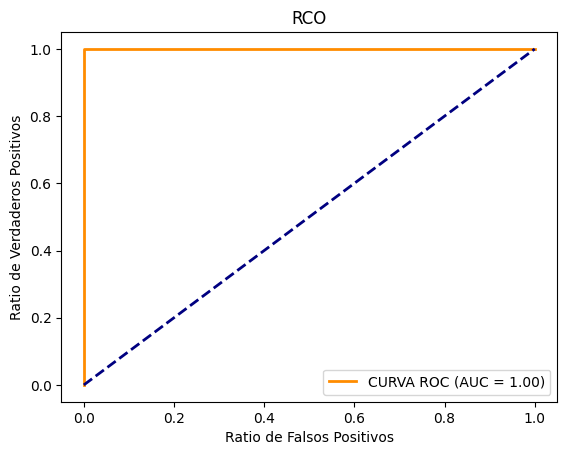

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CURVA ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('RCO')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_processed, y, cv=cv, scoring='accuracy')
print("Accuracy promedio:", scores.mean())


Accuracy promedio: 0.9970343967833125


In [ ]:
import numpy as np


feature_importance = pd.Series(np.abs(model.coef_[0]), index=X_processed.columns)
print(feature_importance.sort_values(ascending=False).head(10))


playlist_subgenre_throwback      5.791838
playlist_subgenre_soft           5.087677
playlist_subgenre_global         3.749792
playlist_subgenre_mainstream     3.670789
playlist_subgenre_bedroom        2.967393
playlist_subgenre_modern         2.540624
playlist_subgenre_classic        1.592813
playlist_subgenre_reggaeton      1.285675
playlist_subgenre_chill          1.153470
playlist_subgenre_alternative    1.108768
dtype: float64


In [ ]:
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

X_numerical = X[numerical_columns]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)
X_scaled = pd.DataFrame(X_scaled, columns=numerical_columns)

X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Forma de los datos numéricos de entrenamiento:", X_train_num.shape, y_train.shape)
print("Forma de los datos numéricos de prueba:", X_test_num.shape, y_test.shape)


Forma de los datos numéricos de entrenamiento: (1348, 14) (1348,)
Forma de los datos numéricos de prueba: (338, 14) (338,)


Matriz de confusión:
[[259   7]
 [ 56  16]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       266
           1       0.70      0.22      0.34        72

    accuracy                           0.81       338
   macro avg       0.76      0.60      0.61       338
weighted avg       0.80      0.81      0.77       338



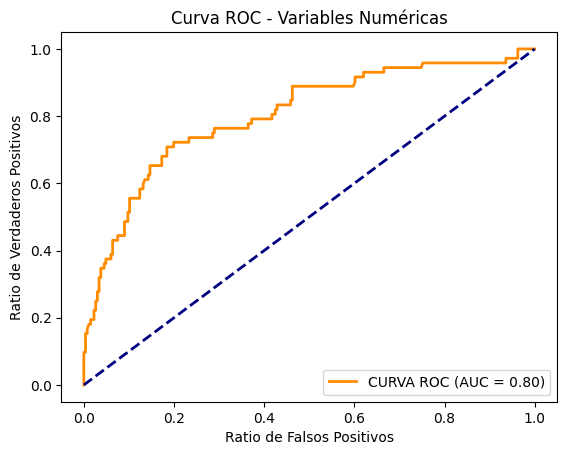

In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_num, y_train)

y_pred = model.predict(X_test_num)
y_pred_proba = model.predict_proba(X_test_num)[:, 1]

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'CURVA ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC - Variables Numéricas')
plt.legend(loc='lower right')
plt.show()


Balance de clases después del submuestreo: is_pop
1    285
0    285
Name: count, dtype: int64
Matriz de confusión:
[[203  63]
 [ 21  51]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       266
           1       0.45      0.71      0.55        72

    accuracy                           0.75       338
   macro avg       0.68      0.74      0.69       338
weighted avg       0.81      0.75      0.77       338


Precisión promedio de validación cruzada (solo sonido): 0.6737

Características más importantes (según coeficientes, solo sonido):
track_popularity    0.900074
valence             0.255951
mode                0.138366
loudness            0.125318
energy              0.058023
danceability        0.013002
acousticness        0.002880
liveness           -0.028675
tempo              -0.032487
instrumentalness   -0.144657
dtype: float64


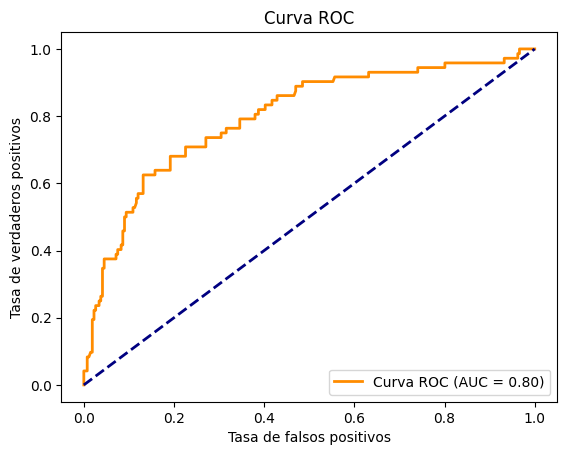

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import classification_report



numerical_columns_sonido = ['track_popularity', 'loudness', 'mode', 'danceability',
                            'energy', 'key', 'speechiness', 'acousticness',
                            'instrumentalness', 'liveness', 'valence', 'tempo']


X_sonido = X[numerical_columns_sonido]


X_train_sonido, X_test_sonido, y_train_sonido, y_test_sonido = train_test_split(X_sonido, y,
                                                                                test_size=0.2,
                                                                                random_state=42,
                                                                                stratify=y)


X_train_minority = X_train_sonido[y_train_sonido == 1]
X_train_majority = X_train_sonido[y_train_sonido == 0]


X_train_majority_downsampled, y_train_majority_downsampled = resample(X_train_majority,
                                                                    y_train_sonido[y_train_sonido == 0],
                                                                    replace=False,
                                                                    n_samples=X_train_minority.shape[0],
                                                                    random_state=42)

X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_sonido[y_train_sonido == 1], y_train_majority_downsampled])


print(f'Balance de clases después del submuestreo: {y_train_balanced.value_counts()}')


scaler_sonido = StandardScaler()
X_train_scaled_sonido = scaler_sonido.fit_transform(X_train_balanced)
X_test_scaled_sonido = scaler_sonido.transform(X_test_sonido)

model_sonido = LogisticRegression(random_state=42, max_iter=1000)
model_sonido.fit(X_train_scaled_sonido, y_train_balanced)


y_pred_sonido = model_sonido.predict(X_test_scaled_sonido)
print("Matriz de confusión:")
print(confusion_matrix(y_test_sonido, y_pred_sonido))
print("\nReporte de clasificación:")
print(classification_report(y_test_sonido, y_pred_sonido))


cv_scores_sonido = cross_val_score(model_sonido, X_train_scaled_sonido, y_train_balanced, cv=5, scoring='accuracy')
print(f"\nPrecisión promedio de validación cruzada (solo sonido): {np.mean(cv_scores_sonido):.4f}")

importance_sonido = model_sonido.coef_[0]
feature_importance_sonido = pd.Series(importance_sonido, index=numerical_columns_sonido)
print("\nCaracterísticas más importantes (según coeficientes, solo sonido):")
print(feature_importance_sonido.sort_values(ascending=False).head(10))


y_pred_proba_sonido = model_sonido.predict_proba(X_test_scaled_sonido)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_sonido, y_pred_proba_sonido)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
smote = SMOTE(random_state=42)
X_train_sonido_smote, y_train_sonido_smote = smote.fit_resample(X_train_sonido, y_train_sonido)

# Reentrenar el modelo con las clases balanceadas por SMOTE
model_sonido_smote = LogisticRegression(random_state=42, max_iter=1000)
model_sonido_smote.fit(X_train_sonido_smote, y_train_sonido_smote)

# Evaluar el modelo
y_pred_sonido_smote = model_sonido_smote.predict(X_test_sonido)
print("Matriz de confusión (SMOTE):")
print(confusion_matrix(y_test_sonido, y_pred_sonido_smote))
print("\nReporte de clasificación (SMOTE):")
print(classification_report(y_test_sonido, y_pred_sonido_smote))

# Realizar validación cruzada con SMOTE
cv_scores_sonido_smote = cross_val_score(model_sonido_smote, X_train_sonido_smote, y_train_sonido_smote, cv=5, scoring='accuracy')
print(f"\nPrecisión promedio de validación cruzada (SMOTE): {np.mean(cv_scores_sonido_smote):.4f}")


Matriz de confusión (SMOTE):
[[209  57]
 [ 20  52]]

Reporte de clasificación (SMOTE):
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       266
           1       0.48      0.72      0.57        72

    accuracy                           0.77       338
   macro avg       0.69      0.75      0.71       338
weighted avg       0.82      0.77      0.79       338


Precisión promedio de validación cruzada (SMOTE): 0.6877


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np


model_xgb = XGBClassifier(random_state=42)


X_train_scaled_sonido = np.array(X_train_scaled_sonido)
y_train_sonido = np.array(y_train_sonido)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_scores_xgb = []
for train_idx, val_idx in kf.split(X_train_scaled_sonido, y_train_sonido):
    X_train_fold, X_val_fold = X_train_scaled_sonido[train_idx], X_train_scaled_sonido[val_idx]
    y_train_fold, y_val_fold = y_train_sonido[train_idx], y_train_sonido[val_idx]

    model_xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_xgb.predict(X_val_fold)


    accuracy = (y_pred_fold == y_val_fold).mean()
    cv_scores_xgb.append(accuracy)

print(f"\nPrecisión promedio de validación cruzada (XGBoost): {np.mean(cv_scores_xgb):.4f}")



Precisión promedio de validación cruzada (XGBoost): 0.7671


In [ ]:
from imblearn.over_sampling import SMOTE



model_xgb = XGBClassifier(random_state=42)


X_train_scaled_sonido = np.array(X_train_scaled_sonido)
y_train_sonido = np.array(y_train_sonido)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_sonido, y_train_sonido)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_scores_xgb = []
y_true_all = []
y_pred_all = []

for train_idx, val_idx in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_idx], X_train_smote[val_idx]
    y_train_fold, y_val_fold = y_train_smote[train_idx], y_train_smote[val_idx]

    model_xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_xgb.predict(X_val_fold)


    accuracy = (y_pred_fold == y_val_fold).mean()
    cv_scores_xgb.append(accuracy)

    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_fold)

print(f"\nPrecisión promedio de validación cruzada con SMOTE (XGBoost): {np.mean(cv_scores_xgb):.4f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_true_all, y_pred_all))

print("\nReporte de clasificación (incluyendo F1-score):")
print(classification_report(y_true_all, y_pred_all))



Precisión promedio de validación cruzada con SMOTE (XGBoost): 0.8650

Matriz de confusión:
[[895 168]
 [119 944]]

Reporte de clasificación (incluyendo F1-score):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1063
           1       0.85      0.89      0.87      1063

    accuracy                           0.87      2126
   macro avg       0.87      0.87      0.86      2126
weighted avg       0.87      0.87      0.86      2126



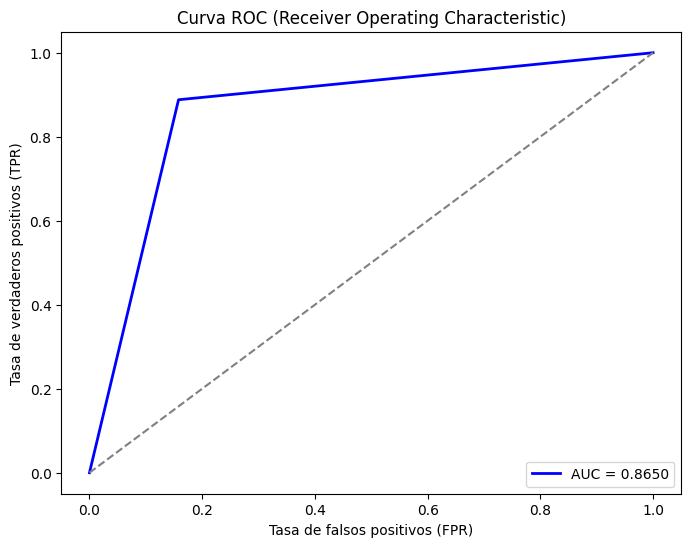

In [ ]:

fpr, tpr, thresholds = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report


model_xgb = XGBClassifier(random_state=42)

X_train_scaled_sonido = np.array(X_train_scaled_sonido)
y_train_sonido = np.array(y_train_sonido)

smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled_sonido, y_train_sonido)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


cv_scores_xgb = []
y_true_all = []
y_pred_all = []

for train_idx, val_idx in kf.split(X_train_smoteenn, y_train_smoteenn):
    X_train_fold, X_val_fold = X_train_smoteenn[train_idx], X_train_smoteenn[val_idx]
    y_train_fold, y_val_fold = y_train_smoteenn[train_idx], y_train_smoteenn[val_idx]

    model_xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = model_xgb.predict(X_val_fold)


    accuracy = (y_pred_fold == y_val_fold).mean()
    cv_scores_xgb.append(accuracy)

    y_true_all.extend(y_val_fold)
    y_pred_all.extend(y_pred_fold)


print(f"\nPrecisión promedio de validación cruzada con SMOTEENN (XGBoost): {np.mean(cv_scores_xgb):.4f}")


print("\nMatriz de confusión:")
print(confusion_matrix(y_true_all, y_pred_all))

print("\nReporte de clasificación (incluyendo F1-score):")
print(classification_report(y_true_all, y_pred_all))



Precisión promedio de validación cruzada con SMOTEENN (XGBoost): 0.9524

Matriz de confusión:
[[503  40]
 [ 25 799]]

Reporte de clasificación (incluyendo F1-score):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       543
           1       0.95      0.97      0.96       824

    accuracy                           0.95      1367
   macro avg       0.95      0.95      0.95      1367
weighted avg       0.95      0.95      0.95      1367



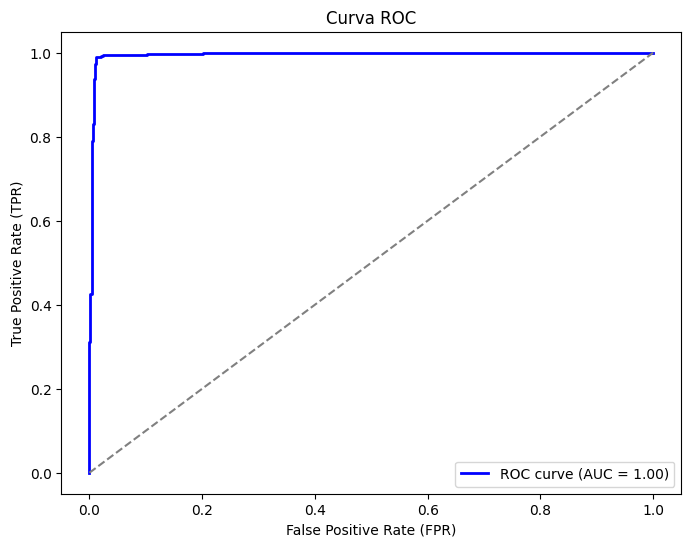

In [ ]:
y_prob = model_xgb.predict_proba(X_train_smoteenn)[:, 1]


fpr, tpr, thresholds = roc_curve(y_train_smoteenn, y_prob)


roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


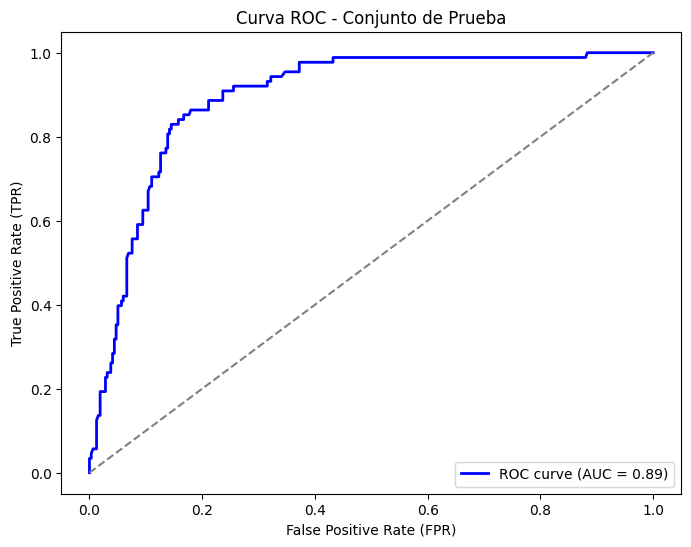

AUC en el conjunto de prueba: 0.8940


In [ ]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred = model_xgb.predict(X_test)
y_test_prob = model_xgb.predict_proba(X_test)[:, 1]


fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - Conjunto de Prueba')
plt.legend(loc='lower right')
plt.show()

print(f'AUC en el conjunto de prueba: {roc_auc_test:.4f}')


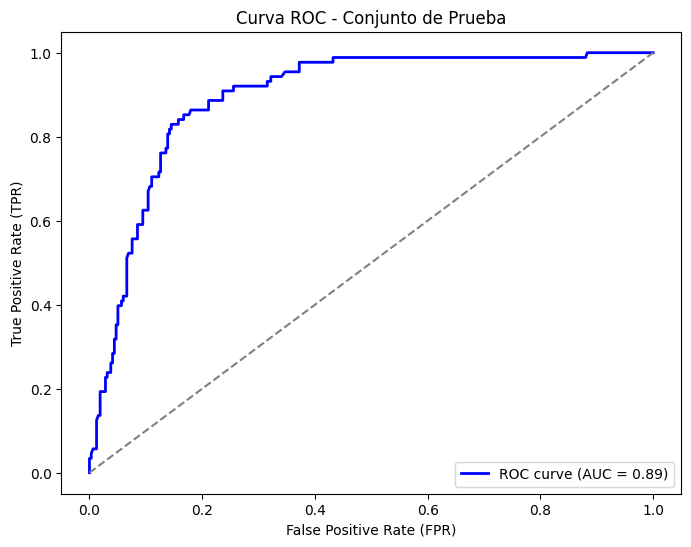

AUC en el conjunto de prueba: 0.8940

Matriz de confusión en el conjunto de prueba:
[[240  77]
 [  8  80]]

Reporte de clasificación en el conjunto de prueba (incluyendo F1-score):
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       317
           1       0.51      0.91      0.65        88

    accuracy                           0.79       405
   macro avg       0.74      0.83      0.75       405
weighted avg       0.87      0.79      0.81       405



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt


y_test_pred = model_xgb.predict(X_test)
y_test_prob = model_xgb.predict_proba(X_test)[:, 1]


fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - Conjunto de Prueba')
plt.legend(loc='lower right')
plt.show()

print(f'AUC en el conjunto de prueba: {roc_auc_test:.4f}')

conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nMatriz de confusión en el conjunto de prueba:")
print(conf_matrix_test)

class_report_test = classification_report(y_test, y_test_pred)
print("\nReporte de clasificación en el conjunto de prueba (incluyendo F1-score):")
print(class_report_test)
